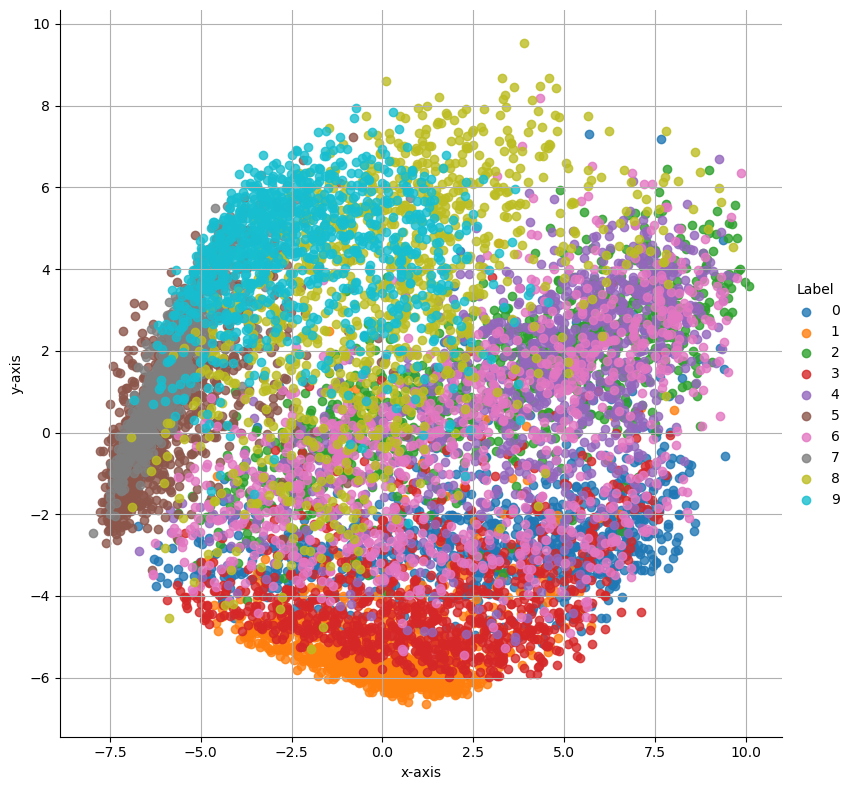

In [1]:
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

Fashion_mnist_test_transform = transforms.Compose([transforms.ToTensor()])
testset_Fashion_mnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=Fashion_mnist_test_transform)
FM_test = DataLoader(testset_Fashion_mnist, batch_size=32, shuffle=False, num_workers=2)
FM_test_images = []
FM_test_labels = []
for batch in FM_test:
    images, labels = batch
    images_flat = images.view(images.shape[0], -1)
    FM_test_images.append(images_flat.numpy())
    FM_test_labels.append(labels.numpy())
FM_test_images = np.vstack(FM_test_images)
FM_test_labels = np.concatenate(FM_test_labels)

X_ = pd.DataFrame(data=FM_test_images) # test data
y_ = pd.Series(data=FM_test_labels) # test label

pca = PCA(n_components= 10)
test_PCA = pca.fit_transform(X_)
test_PCA = pd.DataFrame(data = test_PCA)
testDF = pd.DataFrame(data=test_PCA.loc[:,0:1], index=test_PCA.index)
testDF = pd.concat((testDF,y_), axis=1, join="inner")
testDF.columns = ["x-axis", "y-axis", "Label"]
sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
plt.grid()

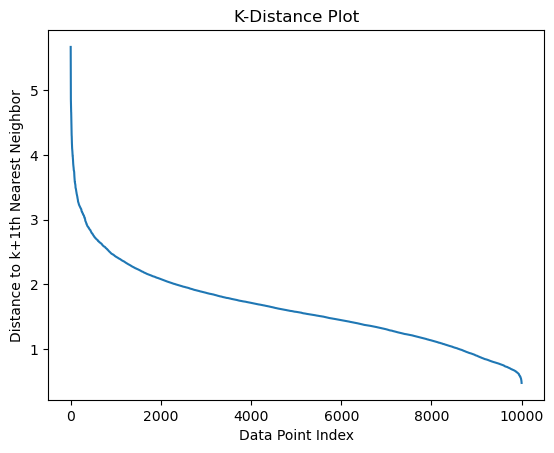

In [2]:
from sklearn.neighbors import NearestNeighbors

# Create NearestNeighbors object
neighbors = NearestNeighbors(n_neighbors=11, algorithm='auto')

neighbors.fit(test_PCA)

distances, indices = neighbors.kneighbors(test_PCA)

# Sort distances in descending order
sorted_distances = np.sort(distances[:, -1])[::-1]


# Plot the k-distance plot
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.xlabel('Data Point Index')
plt.ylabel('Distance to k+1th Nearest Neighbor')
plt.title('K-Distance Plot')
plt.show()


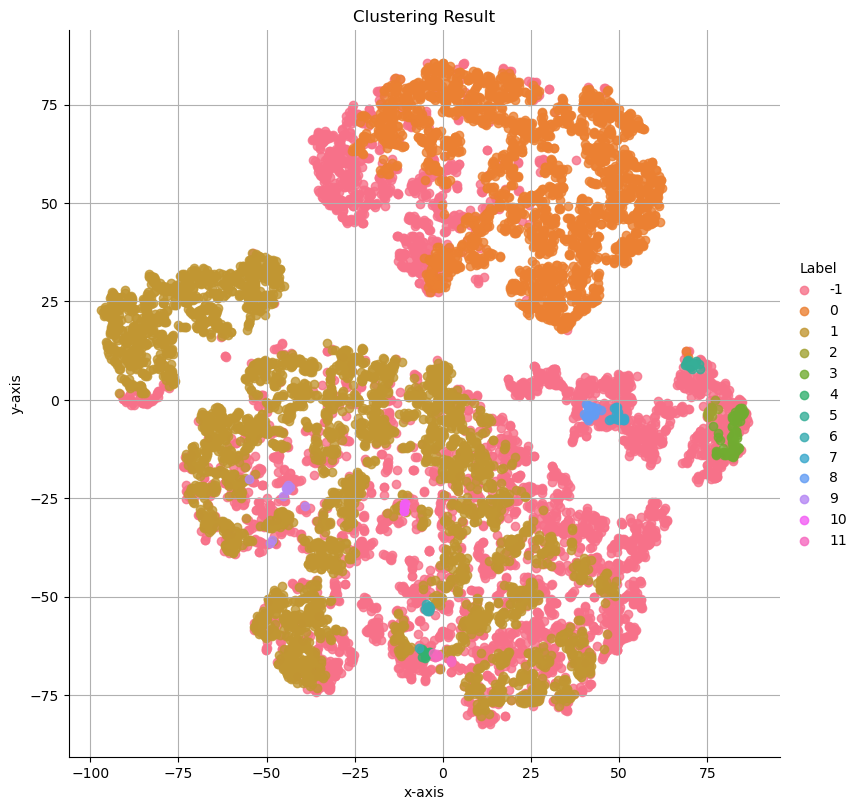

In [17]:
n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration, init=init)

X_test_tSNE = tSNE.fit_transform(test_PCA.loc[:,:])
X_test_tSNE = pd.DataFrame(data=X_test_tSNE)
testDF = pd.DataFrame(data=X_test_tSNE.loc[:,:], index=test_PCA.index)
testDF = pd.concat((testDF,y_), axis=1, join="inner")
testDF.columns = ["x-axis", "y-axis", "Label"]

n_clusters = 10
dbscan = DBSCAN(eps=1.5, min_samples=11, n_jobs=4).fit(test_PCA)#1.5 11
cluster_labels = dbscan.labels_

testDF["Label"] = cluster_labels
sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
plt.title("Clustering Result")
plt.grid()

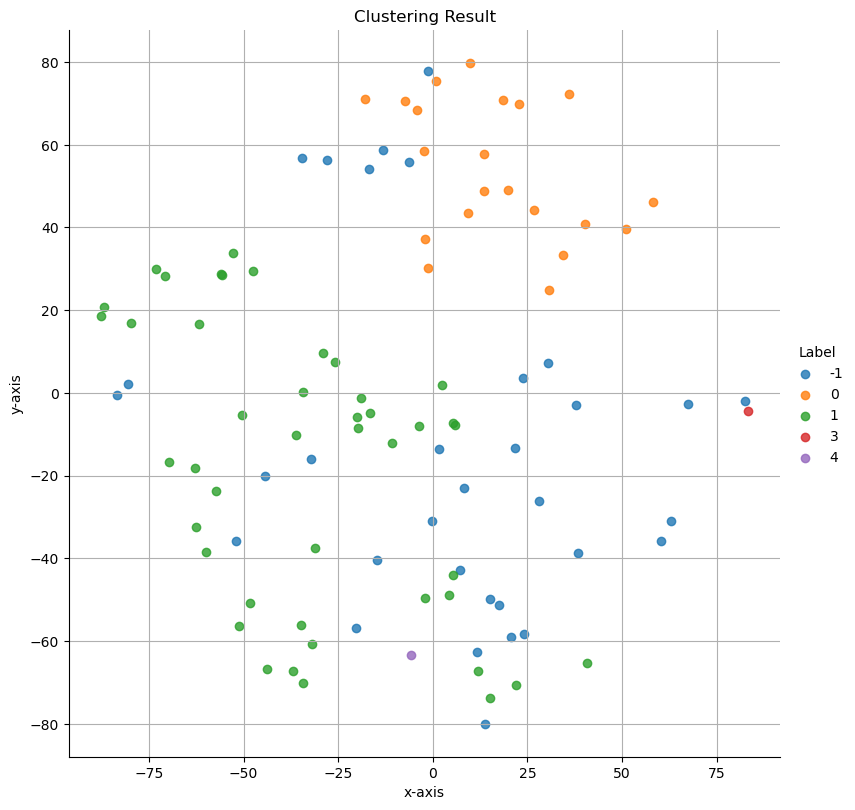

In [21]:
testDF_sample = testDF.sample(n=100)

sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF_sample, fit_reg=False, height=8)
plt.title("Clustering Result")
plt.grid()

In [22]:
from sklearn.metrics import adjusted_rand_score

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(FM_test_labels, cluster_labels)

# Print the ARI score
print("Adjusted Rand Index (ARI):", ari)

Adjusted Rand Index (ARI): 0.1571937349042262


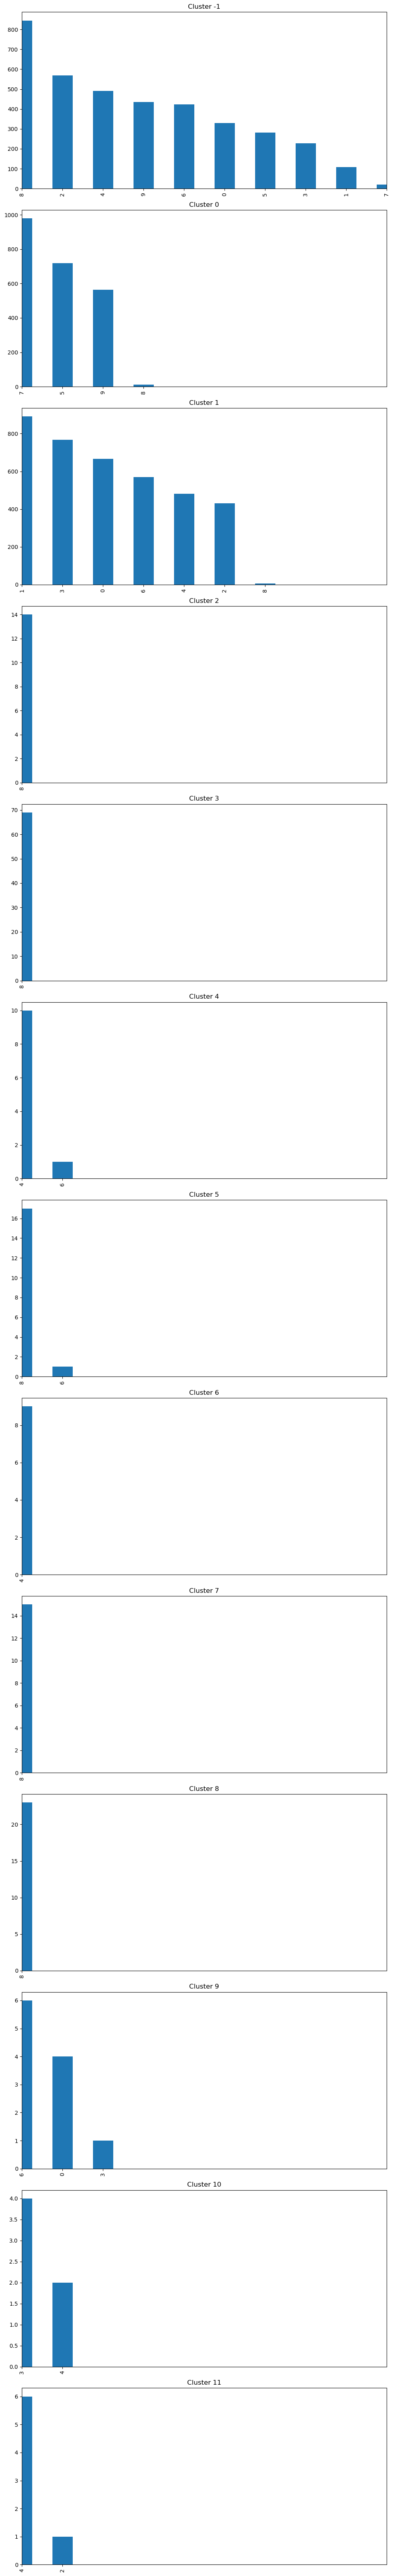

In [23]:
c_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'Actual': FM_test_labels
})

cluster_ids = sorted(c_df['Cluster'].unique())
n_clusters = len(cluster_ids)

fig, axs = plt.subplots(n_clusters, figsize=(10, 5 * n_clusters))

# set common x-axis limits
xmin = c_df['Actual'].min()
xmax = c_df['Actual'].max()

for i, cluster_id in enumerate(cluster_ids):
    cluster_df = c_df[c_df['Cluster'] == cluster_id]
    cluster_counts = cluster_df['Actual'].value_counts()
    cluster_counts.plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Cluster {cluster_id}')
    axs[i].set_xlim([xmin, xmax])
plt.tight_layout()
plt.show()